/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


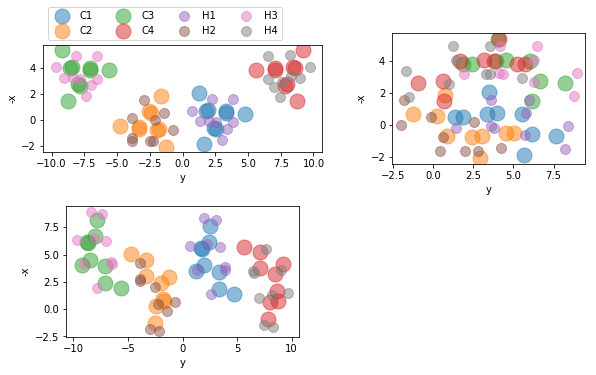

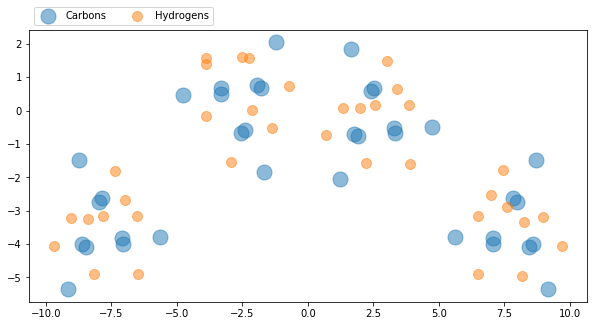

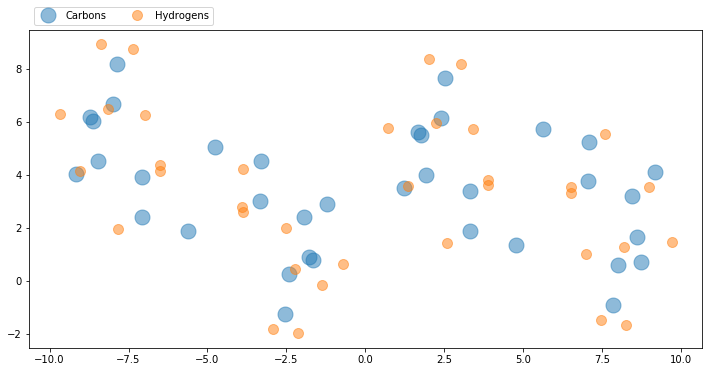

In [73]:
import numpy
import math
from matplotlib import pyplot

''' Atomic fractional coordiantes x/a, y/b, and z/c
from (1988 Macromolecules Immiczi and Iannelil) 
Comments indicate bonding. '''

C1 = numpy.array([[-0.0727, 0.2291, 0.2004],  #C3 0: 1
                  [-0.0765, 0.1592, 0.2788],  #C1 1: 0 2
                  [-0.1021, 0.1602, 0.5098],  #C2 2: 1 4
                  [-0.3087, 0.0589, 0.4941],  #C3 3: 4
                  [-0.1146, 0.0928, 0.6057],  #C1 4: 2 3 5
                  [-0.1044, 0.0854, 0.8428],  #C2 5: 4 7
                  [ 0.2775, 0.0797, 0.9260],  #C3 6: 7
                  [ 0.0872, 0.1156, 0.9730],  #C1 7: 5 6 8
                  [ 0.1026, 0.1221, 1.2109]]) #C2 8: 7

''' Angle between c vector and x-axis. '''
beta = 99.5 * numpy.pi / 180.0

''' Columns of unit_cell are the a, b, and c cell vectors. '''
unit_cell = numpy.array([[6.63,  0.00, 6.50*numpy.cos(beta)],
                         [0.00, 20.78, 0.0],
                         [0.00,  0.00, 6.50*numpy.sin(beta)]])


def apply_space_group(C1):
    ''' Edited symmetry operations to make figure match - not checked '''
    C2, C3, C4 = C1.copy(), C1.copy(), C1.copy()

    C2[:,0] = -C2[:,0]
    C2[:,1] = -C2[:,1]
    C2[:,2] = -C2[:,2] + 1.0

    C3[:,0] =  C3[:,0] - 0.5
    C3[:,1] =  C3[:,1] - 0.5
    C3[:,2] =  C3[:,2]

    C4[:,0] =  C4[:,0] - 0.5
    C4[:,1] = -C4[:,1] + 0.5
    C4[:,2] = -C4[:,2] + 1.0   
    
    return C1, C2, C3, C4



def apply_hydrogens(C):
    ''' Construction of hydrogens from Theodorou (MD of aPP Melts) with 
    l_H=0.11 nm and theta_H=1.28 rad and c=+1 in C1 & C4 and c=-1 in C2 & C3'''   
    
    temp = numpy.zeros(3)
    H = numpy.zeros([9,3])
    l_H = 1.1
    theta_H = 1.28
    c=1       

    # Non-Methyl Hydrogens (Chiral and Gemini)
    # Chiral(Pendant) hydrogen
    # r_Hi = r_Ci+c*l_H*[((r_Ri)-(r_Ci-1))cross((r_Ri)-(r_Ci+1))/|((r_Ri)-(r_Ci-1))cross((r_Ri)-(r_Ci+1))|]
    
    def chiral_H_direction(Ci,Cj,Ck):      
        return unit_vector(numpy.cross(Ci-Cj, Ci-Ck))
    
    temp[0] = C[8,0]
    temp[1] = C[8,1]    
    temp[2] = C[8,2]-1
    H[0,:] = C[1,:] + c*l_H*chiral_H_direction(C[0,:],temp[:],C[2,:])
    H[3,:] = C[4,:] + c*l_H*chiral_H_direction(C[3,:],C[2,:],C[5,:])
    H[6,:] = C[7,:] + c*l_H*chiral_H_direction(C[6,:],C[5,:],C[8,:])

    # Gemini hydrogens 
    # b(i) = rc(i) - rc(i-1)/|rc(i)-rc(i-1)|
    b = [None]*6
        
    b[0] = unit_vector(C[2,:] - C[1,:])
    b[1] = unit_vector(C[4,:] - C[2,:])
    
    b[2] = unit_vector(C[5,:] - C[4,:])
    b[3] = unit_vector(C[7,:] - C[5,:])
    
    b[4] = unit_vector(C[8,:] - C[7,:])
    temp[0] = C[1,0]
    temp[1] = C[1,1]
    temp[2] = C[1,2]+1
    b[5] = unit_vector(temp[:] - C[8,:])


    # u(i) = (b(i) - b(i+1))/sqrt(2*(1-b(i).b(i+1))    
    u = [None]*3

    def bisector_vector(b1,b2):
        return (b1 - b2) / math.sqrt(2.0*(1.0 - numpy.dot(b1,b2)))
      
    # v(i) = (b(i) X b(i+1))/|b(i) X b(i+1)|
    v = [None]*3

    def plane_normal(b1,b2):
        return numpy.cross(b1,b2)/numpy.linalg.norm(numpy.cross(b1,b2))

    # rH(i) = rc(i) + lH*(sin(thetaH/2)*u(i) +- cos(thetaH/2)*v(i))
    def gemini_hydrogen(u,v,n):
        if n == 1:
            return (numpy.sin(theta_H/2)*u+numpy.cos(theta_H/2)*v)
        else:
            return (numpy.sin(theta_H/2)*u-numpy.cos(theta_H/2)*v)
    
    v[0] = plane_normal(b[0],b[1])
    u[0] = bisector_vector(b[0],b[1])
    H[1,:] = C[2,:]+l_H*gemini_hydrogen(u[0],v[0],1)
    H[2,:] = C[2,:]+l_H*gemini_hydrogen(u[0],v[0],2)

    v[1] = plane_normal(b[2],b[3])
    u[1] = bisector_vector(b[2],b[3])
    H[4,:] = C[5,:]+l_H*gemini_hydrogen(u[1],v[1],1)
    H[5,:] = C[5,:]+l_H*gemini_hydrogen(u[1],v[1],2)

    v[2] = plane_normal(b[4],b[5])
    u[2] = bisector_vector(b[4],b[5])
    H[7,:] = C[8,:]+l_H*gemini_hydrogen(u[2],v[2],1)
    H[8,:] = C[8,:]+l_H*gemini_hydrogen(u[2],v[2],2)  
    
    '''
    # Methyl Group Hydrogens 
    for i in range(0,9,3):
        H[9+i,0] = C[1+i,0] + 1.037
        H[9+i,1] = C[1+i,1] 
        H[9+i,2] = C[1+i,2] - 0.37
        H[10+i,0] = C[1+i,0] - 0.5185        
        H[10+i,1] = C[1+i,1] + 0.898
        H[10+i,2] = C[1+i,2] - 0.37
        H[11+i,0] = C[1+i,0] - 0.5185
        H[11+i,1] = C[1+i,1] - 0.898       
        H[11+i,2] = C[1+i,2] - 0.37
    '''
    
    return H


def plot_unit_cell(CC):
    
    C = numpy.vstack([numpy.dot(C, unit_cell) for C in apply_space_group(CC)])
    
    H = numpy.zeros([36,3])
    
    for i in range(4):
        H[9*i:9*(i+1),:] = apply_hydrogens(C[9*i:9*(i+1),:]) 
    
    lx, ly = unit_cell[0,0], unit_cell[1,1]
    
    figure = pyplot.figure(figsize=(9,5))
    aC = pyplot.subplot(221)
    aH = pyplot.subplot(221)
    
    aC.plot(C[:9,1],    -C[:9,0],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,1],  -C[9:18,0],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,1], -C[18:27,0], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,1], -C[27:36,0], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('y')
    aC.set_ylabel('-x')
    aC.set_aspect('equal')
    
    aH.plot(H[:9,1],    -H[:9,0],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[9:18,1],  -H[9:18,0],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[18:27,1], -H[18:27,0], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[27:36,1], -H[27:36,0], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')
    
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    aC = pyplot.subplot(222)
    aH = pyplot.subplot(222)
    
    aC.plot(C[:9,2],    -C[:9,0],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,2],  -C[9:18,0],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,2], -C[18:27,0], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,2], -C[27:36,0], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('z')
    aC.set_ylabel('-x')
    aC.set_aspect('equal')
    
    aH.plot(H[:9,2],    -H[:9,0],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[9:18,2],  -H[9:18,0],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[18:27,2], -H[18:27,0], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[27:36,2], -H[27:36,0], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')

    aC = pyplot.subplot(223)
    aH = pyplot.subplot(223)

    aC.plot(C[:9,1],    C[:9,2],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,1],  C[9:18,2],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,1], C[18:27,2], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,1], C[27:36,2], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('y')
    aC.set_ylabel('z')
    aC.set_aspect('equal')
    
    aH.plot(H[:9,1],    H[:9,2],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[9:18,1],  H[9:18,2],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[18:27,1], H[18:27,2], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[27:36,1], H[27:36,2], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')
    
    pyplot.tight_layout()
    

def unit_vector(v):
    return v / numpy.linalg.norm(v)

        
def crystal(a,b,c):
    ''' Creating the initial crystalline system - a & b & c are the dimensions of the system '''     
    C = numpy.vstack([C for C in apply_space_group(C1)])    
    Carbons = numpy.zeros([a*b*c*36,3])    
    Hydrogens = numpy.zeros([a*b*c*36,3])
                
    for i in range(a):
        Carbons[(36*i):(36*(i+1)),0] = C[:,0] + float(i)
        Carbons[(36*i):(36*(i+1)),1] = C[:,1]
        Carbons[(36*i):(36*(i+1)),2] = C[:,2]   
    
    for j in range(1,b):
        Carbons[36*(a*j):36*(a*(j+1)),0] = Carbons[0:36*a,0]
        Carbons[36*(a*j):36*(a*(j+1)),1] = Carbons[0:36*a,1] + float(j)         
        Carbons[36*(a*j):36*(a*(j+1)),2] = Carbons[0:36*a,2] 
        
    for k in range(1,c):
        Carbons[36*(a*b*k):36*(a*b*(k+1)),0] = Carbons[0:36*a*b,0]
        Carbons[36*(a*b*k):36*(a*b*(k+1)),1] = Carbons[0:36*a*b,1]          
        Carbons[36*(a*b*k):36*(a*b*(k+1)),2] = Carbons[0:36*a*b,2] + float(k)                    
    
    Carbons = numpy.dot(Carbons, unit_cell)   
    
    # number of chains = a*b*c*4
    for i in range(a*b*c*4):        
        Hydrogens[9*i:9*(i+1),:] = apply_hydrogens(Carbons[9*i:9*(i+1),:])            
    
    
    
    return Carbons, Hydrogens



def plot_crystal(C, H):
    
    fig1 = pyplot.figure(figsize = (10,5))      
    aC1 = pyplot.plot(C[:,1], C[:,0],'.', ms=30, alpha=0.5, label='Carbons')
    aH1 = pyplot.plot(H[:,1], H[:,0],'.', ms=20, alpha=0.5, label='Hydrogens')
    
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    
    fig2 = pyplot.figure(figsize = (10,5))    
    aC2 = pyplot.plot(C[:,1], C[:,2],'.', ms=30, alpha=0.5, label='Carbons')
    aH2 = pyplot.plot(H[:,1], H[:,2],'.', ms=20, alpha=0.5, label='Hydrogens')
    
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    pyplot.tight_layout()

plot_unit_cell(C1)

C, H = crystal(1,1,1)

plot_crystal(C, H)


In [74]:
# Determine which carbn atoms are bonded to each other.
def carbon_bonds(C):
    for i in range(len((C))):
        s = '{}:'.format(i)
        for j in range(len(C)):
            d = numpy.linalg.norm(C[i,:]-C[j,:])
            if i != j and d < 1.6:
                s += ' {} '.format(j)
        print(s)
    
    
carbon_bonds(C)


# Determine which hydrogen is connected to what carbon
def hydrogen_bonds(C,H):    
    for i in range(len(C)):
        h1 = '{}:'.format(i)
        for j in range(len(H)):
            dist = numpy.linalg.norm(C[i,:]-H[j,:])
            if abs(dist - 1.1) < 0.1:
                h1 += '{} '.format(j)
        print(h1)

hydrogen_bonds(C,H)


0: 1 
1: 0  2 
2: 1  4 
3: 4 
4: 2  3  5 
5: 4  7 
6: 7 
7: 5  6  8 
8: 7 
9: 10 
10: 9  11 
11: 10  13 
12: 13 
13: 11  12  14 
14: 13  16 
15: 16 
16: 14  15  17 
17: 16 
18: 19 
19: 18  20 
20: 19  22 
21: 22 
22: 20  21  23 
23: 22  25 
24: 25 
25: 23  24  26 
26: 25 
27: 28 
28: 27  29 
29: 28  31 
30:
31: 29  32 
32: 31 
33: 34 
34: 33  35 
35: 34 
0:
1:0 
2:1 2 
3:
4:3 
5:4 5 
6:
7:6 
8:7 8 
9:
10:9 
11:10 11 
12:
13:12 
14:13 14 
15:
16:15 
17:16 17 
18:
19:18 
20:19 20 
21:
22:21 
23:22 23 
24:
25:24 
26:25 26 
27:
28:27 
29:28 29 
30:
31:30 
32:31 32 
33:
34:33 
35:34 35 


In [75]:
# Dteremine the angle between the Carbons

def carbon_angles(C):        
    phi = [None]*4
    phi[0] = numpy.dot((C[2,:]-C[1,:]),(C[4,:]-C[2,:]))/(numpy.linalg.norm(C[2,:]-C[1,:])*numpy.linalg.norm(C[4,:]-C[2,:]))
    phi[1] = numpy.dot((C[4,:]-C[2,:]),(C[5,:]-C[4,:]))/(numpy.linalg.norm(C[4,:]-C[2,:])*numpy.linalg.norm(C[5,:]-C[4,:]))
    phi[2] = numpy.dot((C[5,:]-C[4,:]),(C[7,:]-C[5,:]))/(numpy.linalg.norm(C[5,:]-C[4,:])*numpy.linalg.norm(C[7,:]-C[5,:]))    
    phi[3] = numpy.dot((C[7,:]-C[5,:]),(C[8,:]-C[7,:]))/(numpy.linalg.norm(C[7,:]-C[5,:])*numpy.linalg.norm(C[8,:]-C[7,:]))
    print(phi,'\n')
    
    return phi

phi = numpy.zeros(int(len(C)/4))

'''
for i in range (len(C)):
    carbon_angles(C)
'''


'\nfor i in range (len(C)):\n    carbon_angles(C)\n'